> **tomato juice dataset**
<br>` 'quality' is the target feature for classification `
<br>` the other features are chemical properties of our product `

**Import the main libraries**

In [45]:
import numpy as np
import pandas as pd

from time import time

_import the local library_

In [46]:
# add parent folder path where lib folder is
import sys
if ".." not in sys.path:import sys; sys.path.insert(0, '..') 

In [47]:
from mylib import show_labels_dist, show_metrics, bias_var_metrics

**Import the Dataset**

In [48]:
## file path: unix style
df = pd.read_csv('../datasets/tomatjus.csv')

# shape method gives the dimensions of the dataset
print('Dataset dimensions: {} rows, {} columns'.format(
    df.shape[0], df.shape[1]))

Dataset dimensions: 1599 rows, 12 columns


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  pulp                  1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


***
**Data Preparation and EDA** (unique to this dataset)
* _Check for missing values_
* _Quick visual check of unique values_
* _Split the classification feature out of the dataset_
* _Check column names of categorical attributes ( for get_dummies() )_
* _Check column names of numeric attributes ( for Scaling )_

**_Let's skip the checking_**

**Classification target feature**
<br>_Make it a multi-class problem, using text labels_

In [50]:
##  divide into classes by giving a range for quality
##  Make it a multi-class problem: {3,4,5} {6} {7.8}
bins = (2, 5, 6, 8)
group_names = ['Average', 'Premium', 'Special']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)

* Split the classification feature out of the dataset 

In [51]:
## Feature being predicted ("the Right Answer")
labels_col = 'quality'
y = df[labels_col]

## Features used for prediction 
# pandas has a lot of rules about returning a 'view' vs. a copy from slice
# so we force it to create a new dataframe 
X = df.copy()
X.drop(labels_col, axis=1, inplace=True)

***
**<br>Create Test // Train Datasets**
> Split X and y datasets into Train and Test subsets,<br>keeping relative proportions of each class (stratify)

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=50, 
                                                    stratify=y)
# train_test_split does random selection, 
#      so we should reset the dataframe indexes
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [53]:
y_test._is_view

False

**<br>Scaling** comes _after_ test // train split

In [54]:
numeri = X.select_dtypes(include=['float64','int64']).columns
print(numeri.to_list())

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'pulp']


In [55]:
# scaling the Numeric columns 
# StandardScaler range: -1 to 1, MinMaxScaler range: zero to 1

# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# sklearn docs say 
#   "Don't cheat - fit only on training data, then transform both"
#   fit() expects 2D array: reshape(-1, 1) for single col or (1, -1) single row

for i in numeri:
    arr = np.array(X_train[i])
    scale = MinMaxScaler().fit(arr.reshape(-1, 1))
    X_train[i] = scale.transform(arr.reshape(len(arr),1))

    arr = np.array(X_test[i])
    X_test[i] = scale.transform(arr.reshape(len(arr),1))

**<br>Classifier Selection**

In [56]:
# prepare list
models = []

##  --  Linear  --  ## 
from sklearn.linear_model import LogisticRegression 
models.append (("LogReg",LogisticRegression())) 
#from sklearn.linear_model import SGDClassifier 
#models.append (("StocGradDes",SGDClassifier())) 
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
#models.append(("LinearDA", LinearDiscriminantAnalysis())) 
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
#models.append(("QuadraticDA", QuadraticDiscriminantAnalysis())) 

##  --  Support Vector  --  ## 
#from sklearn.svm import SVC 
#models.append(("SupportVectorClf", SVC())) 
#from sklearn.svm import LinearSVC 
#models.append(("LinearSVC", LinearSVC())) 
#from sklearn.linear_model import RidgeClassifier
#models.append (("RidgeClf",RidgeClassifier())) 

##  --  Non-linear  --  ## 
from sklearn.tree import DecisionTreeClassifier 
models.append (("DecisionTree",DecisionTreeClassifier())) 
#from sklearn.naive_bayes import GaussianNB 
#models.append (("GaussianNB",GaussianNB())) 
from sklearn.neighbors import KNeighborsClassifier 
models.append(("K-NNeighbors", KNeighborsClassifier())) 

##  --  Ensemble: bagging  --  ## 
from sklearn.ensemble import RandomForestClassifier 
models.append(("RandomForest", RandomForestClassifier())) 
##  --  Ensemble: boosting  --  ## 
#from sklearn.ensemble import AdaBoostClassifier 
#models.append(("AdaBoost", AdaBoostClassifier())) 
#from sklearn.ensemble import GradientBoostingClassifier 
#models.append(("GradientBoost", GradientBoostingClassifier())) 

##  --  NeuralNet (simplest)  --  ## 
#from sklearn.neural_network import MLPClassifier 
#models.append(("MultiLayerPtron", MLPClassifier())) 

print(models)

[('LogReg', LogisticRegression()), ('DecisionTree', DecisionTreeClassifier()), ('K-NNeighbors', KNeighborsClassifier()), ('RandomForest', RandomForestClassifier())]


**<br>Target Label Distributions** (standard block)

In [57]:
# from our local library
show_labels_dist(X_train,X_test,y_train,y_test)

features_train: 1279 rows, 11 columns
features_test:  320 rows, 11 columns

labels_train: 1279 rows, 1 column
labels_test:  320 rows, 1 column

Frequency and Distribution of labels
         quality  %_train  quality  %_test
quality                                   
Average      595    46.52      149   46.56
Premium      510    39.87      128   40.00
Special      174    13.60       43   13.44


**<br>Fit and Predict** (standard block)

In [58]:
# evaluate each model in turn
results = []

print('macro average: unweighted mean per label')
print('weighted average: support-weighted mean per label')
print('MCC: correlation between prediction and ground truth')
print('     (+1 perfect, 0 random prediction, -1 inverse)\n')

for name, clf in models:
    trs = time()
    print('Confusion Matrix:', name)
    
    clf.fit(X_train, y_train)
    ygx = clf.predict(X_test)
    results.append((name, ygx))
    
    tre = time() - trs
    print ("Run Time {} seconds".format(round(tre,2)) + '\n')
    
# Easy way to ensure that the confusion matrix rows and columns
#   are labeled exactly as the classifier has coded the classes
#   [[note the _ at the end of clf.classes_ ]]

    show_metrics(y_test, ygx, clf.classes_)   # from our local library
    print('\nParameters: ', clf.get_params(), '\n\n')

macro average: unweighted mean per label
weighted average: support-weighted mean per label
MCC: correlation between prediction and ground truth
     (+1 perfect, 0 random prediction, -1 inverse)

Confusion Matrix: LogReg
Run Time 0.02 seconds

               pred:Average  pred:Premium  pred:Special
train:Average           120            29             0
train:Premium            44            78             6
train:Special             2            29            12

~~~~
     Average :  FPR = 0.269   FNR = 0.195
     Premium :  FPR = 0.302   FNR = 0.391
     Special :  FPR = 0.022   FNR = 0.721

   macro avg :  FPR = 0.198   FNR = 0.435
weighted avg :  FPR = 0.172   FNR = 0.344

~~~~
              precision    recall  f1-score   support

     Average      0.723     0.805     0.762       149
     Premium      0.574     0.609     0.591       128
     Special      0.667     0.279     0.393        43

    accuracy                          0.656       320
   macro avg      0.654     0.565    

**Bias - Variance Decomposition** (standard block)

In [59]:
# from our local library
# reduce (cross-validation) folds for faster results
folds = 20
for name, clf in models:
    print('Bias // Variance Decomposition:', name)
    bias_var_metrics(X_train,X_test,y_train,y_test,clf,folds)

Bias // Variance Decomposition: LogReg
   Average bias: 0.344
   Average variance: 0.064
   Average expected loss: 0.352  "Goodness": 0.648

Bias // Variance Decomposition: DecisionTree
   Average bias: 0.272
   Average variance: 0.300
   Average expected loss: 0.391  "Goodness": 0.609

Bias // Variance Decomposition: K-NNeighbors
   Average bias: 0.369
   Average variance: 0.213
   Average expected loss: 0.416  "Goodness": 0.584

Bias // Variance Decomposition: RandomForest
   Average bias: 0.266
   Average variance: 0.136
   Average expected loss: 0.308  "Goodness": 0.692



***

***

**<br>Imports** for model comparison - CV

In [60]:
# Default scorer for classification is sklearn.metrics.accuracy_score 
# For imbalanced classification, the accuracy score is often uninformative
# For the list of options see
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# average for each label weighted by support 
#        (number of true instances for each label)
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

eval_metric = ['wtd.avg.accuracy', 
               'balanced_accuracy', 
               'wtd.avg.f1_score', 
               'f1_weighted']

# for graphs
import matplotlib.pyplot as plt

***
**Model Comparison: Cross Validation**

In [61]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
# a variation of KFold that returns stratified folds,  
#   preserving the percentage of samples for each class

# ----  Cross Validation  ---- #
# number of rounds
folds = 3

# choose a metric
scorer = eval_metric[1]
# ----    ---- #

# define the strategy
skf = StratifiedKFold(shuffle=True, random_state = 11, n_splits=folds)

from time import time
trs = time()
print('KFold CV: %i folds with scoring = %s \n\t timer started' % (folds, scorer))

results = []
names = []
for name, model in models:
    print(name, end='')    # no newline at the end
    cv_results = cross_val_score(model, X_train, y_train, cv=skf, scoring=scorer)
    results.append(cv_results)
    names.append(name)
    msg = ":\t%s = %0.3f +/- (%0.3f)" % (scorer, 
                                         cv_results.mean(), 
                                         cv_results.std())
    print(msg)

tre = time() - trs
print ("\tRun Time {} seconds".format(round(tre,2)) + '\n')

KFold CV: 3 folds with scoring = balanced_accuracy 
	 timer started
LogReg:	balanced_accuracy = 0.503 +/- (0.022)
DecisionTree:	balanced_accuracy = 0.583 +/- (0.020)
K-NNeighbors:	balanced_accuracy = 0.541 +/- (0.005)
RandomForest:	balanced_accuracy = 0.643 +/- (0.017)
	Run Time 1.24 seconds



The box shows the middle 50 percent of the data,
the orange line in the middle of each box shows the median of the sample,
and the green triangle in each box shows the mean of the sample.


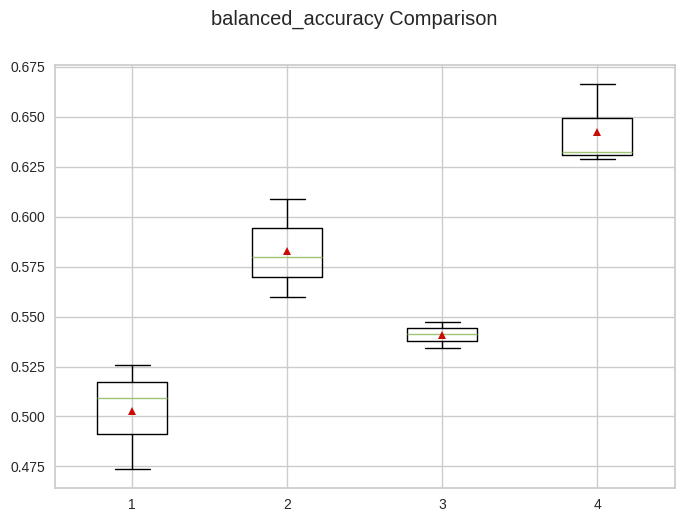

['LogReg', 'DecisionTree', 'K-NNeighbors', 'RandomForest']


In [62]:
# boxplot model comparison
# One box and whisker plot for each algorithm’s sample of results.

ttl = scorer + ' Comparison'
print("The box shows the middle 50 percent of the data,\n"
      "the orange line in the middle of each box shows the median of the sample,\n"
      "and the green triangle in each box shows the mean of the sample.")

fig = plt.figure()
fig.suptitle(ttl)
ax = fig.add_subplot(111)
plt.boxplot(results, showmeans=True)
#ax.set_xticklabels(names)
plt.show()
print(names)

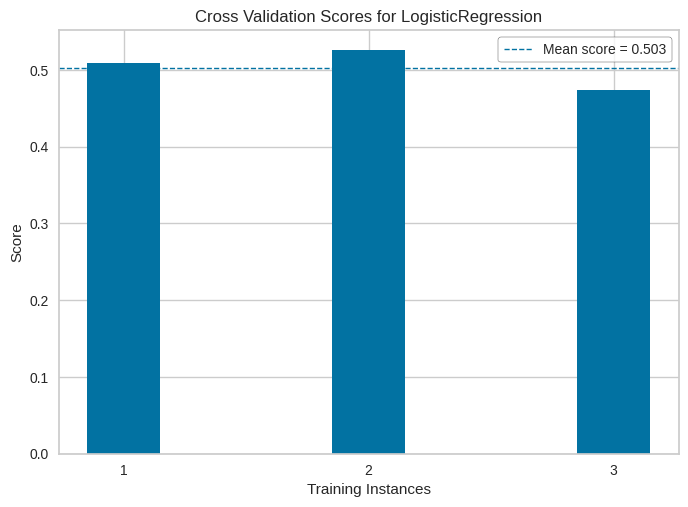

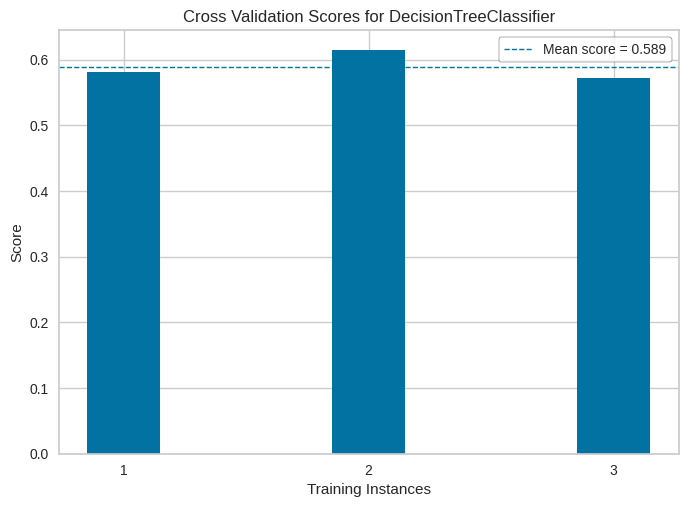

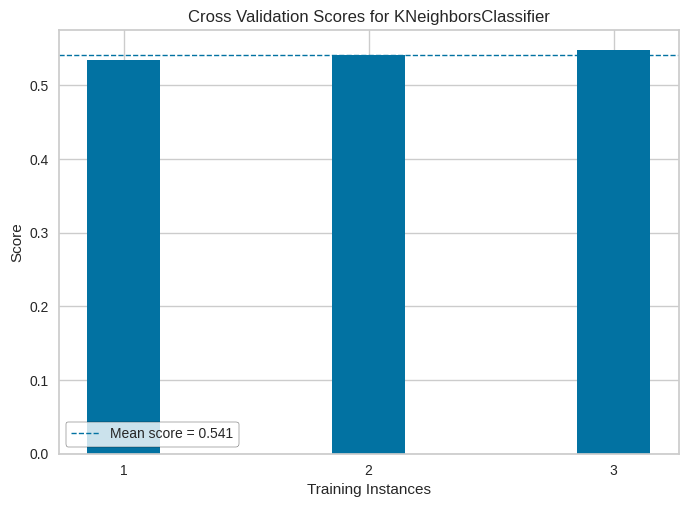

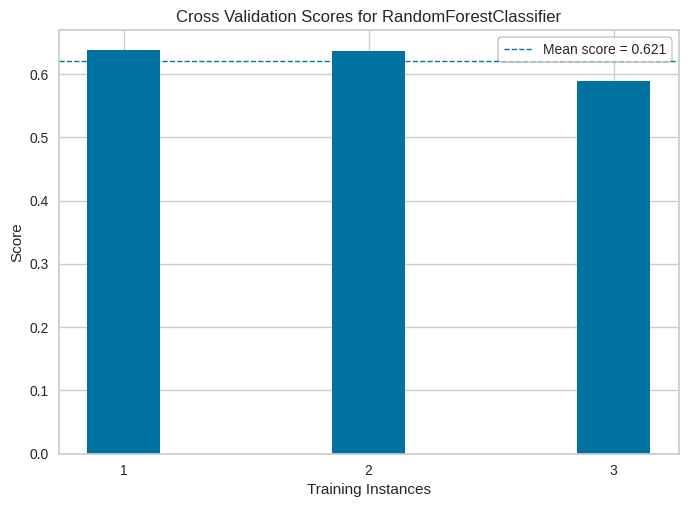

In [63]:
# individual model per-fold results
from yellowbrick.model_selection import cv_scores
for name, model in models:
    viz = cv_scores(model, X_train, y_train, cv=skf, scoring=scorer)

***
**Model Comparison: Bias - Variance Decomposition**

In [64]:
from mlxtend.evaluate import bias_variance_decomp
## bias_variance_decomp() requires 
##    1. numpy ndarrays
##    2. numeric targets
from sklearn.preprocessing import LabelEncoder

# slow because it does num_rounds (default=200) bootstrap cross validation
folds = 12

from time import time
trs = time()
print('Bias-Variance: Model Comparison \n\t timer started')

ytrain = LabelEncoder().fit_transform(y_train)
ytest = LabelEncoder().fit_transform(y_test)

# for graphs
rx = np.arange(len(models))       # the x locations for the groups

cn, bias, var, err = [], [], [], []
for name, clf in models:
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        clf, X_train.values, ytrain, X_test.values, ytest, 
        loss='0-1_loss', num_rounds=folds, random_seed=150)
    err.append(avg_expected_loss)
    bias.append(avg_bias)
    var.append(avg_var)
    cn.append(name)
    
    print(name,end='')    # no newline at the end
    msg=": Bias: %0.3f  Variance: %0.3f  E.loss: %0.3f" % (avg_bias, avg_var, avg_expected_loss)
    print(msg)
    
tre = time() - trs
print ("\tRun Time {} seconds".format(round(tre,2)) + '\n')

Bias-Variance: Model Comparison 
	 timer started
LogReg: Bias: 0.347  Variance: 0.067  E.loss: 0.355
DecisionTree: Bias: 0.297  Variance: 0.289  E.loss: 0.393
K-NNeighbors: Bias: 0.381  Variance: 0.208  E.loss: 0.421
RandomForest: Bias: 0.263  Variance: 0.133  E.loss: 0.308
	Run Time 5.69 seconds



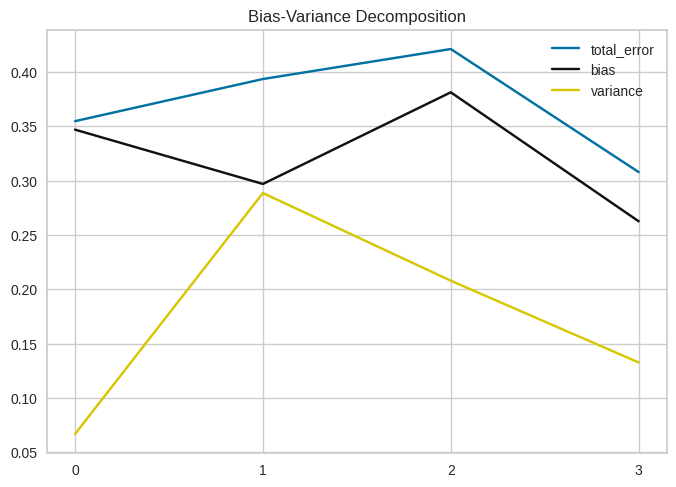

['LogReg', 'DecisionTree', 'K-NNeighbors', 'RandomForest']


In [65]:
# line plot
fig, ax = plt.subplots()
ax.plot(rx, err, 'b', label = 'total_error')
ax.plot(rx, bias, 'k', label = 'bias')
ax.plot(rx, var, 'y', label = 'variance')
ax.legend()
ax.set_xticks(rx)
ax.set_title('Bias-Variance Decomposition')
plt.show()
print(cn)

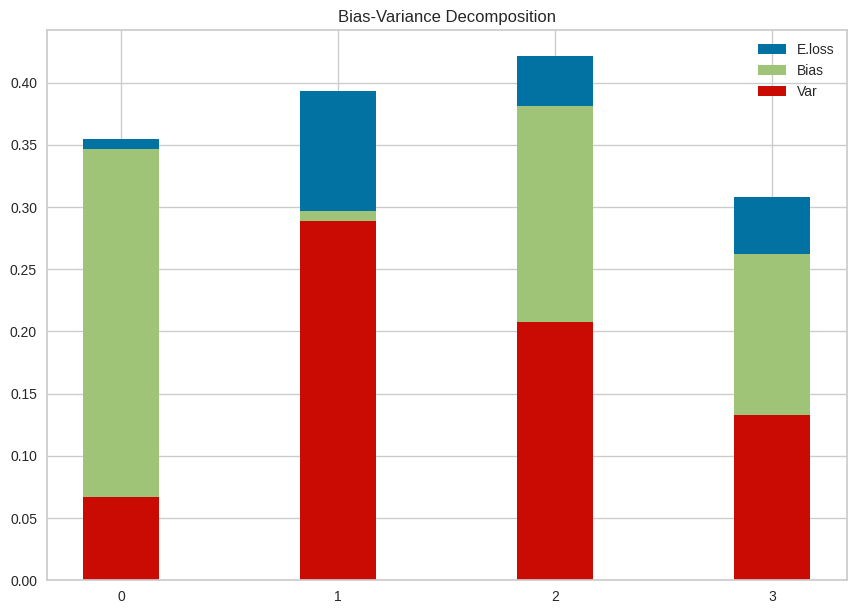

['LogReg', 'DecisionTree', 'K-NNeighbors', 'RandomForest']


In [66]:
# stacked bar plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(rx, err, color = 'b', width= 0.35)
ax.bar(rx, bias, color = 'g', width= 0.35)
ax.bar(rx, var, color = 'r', width= 0.35)
ax.legend(labels=['E.loss', 'Bias', 'Var'])
ax.set_title('Bias-Variance Decomposition')
ax.set_xticks(rx)
plt.show()
print(cn)